# Evolution of CCFs

In [1]:
from IPython.display import FileLink
import os
import imageio.v2 as imageio  

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from matplotlib.pyplot import figure


from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau


from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate

import os
import imageio.v2 as imageio  

## Data

In [3]:
#initial parameters
n = 1000
RV = np.arange(-18000,18001,500)

In [4]:
#initial parameters
na = 1000

In [5]:
data_matrices = {}
for i in range(n):
    filename = f'STARSIM_output_CCFr_{i}.txt'
    data_matrix = np.loadtxt(filename)
    data_matrices[f'd{i}'] = data_matrix

In [6]:
for i in range(na):
    filename = f'STARSIM_output_CCFn_{i}.txt'
    data_matrix = np.loadtxt(filename)
    data_matrices[f'd{i+1000}'] = data_matrix

In [7]:
np.shape(data_matrices['d0'])

(73, 28)

In [8]:
n = 2000

In [9]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'][:,1:]

In [10]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'].T

In [11]:
np.shape(data_matrices['d0'])

(27, 73)

Differential

In [12]:
ccf_total = {}

for i in range(n):
    for j in range(73):
        a = 0
        for k in range(27):
            a += data_matrices[f'd{i}'][k,j]
        ccf_total[f'd{i}',j] = a
    

for i in range(n):
    ccf_total1 = np.zeros(73)
    for k in range(27):
        for j in range(73):
            ccf_total1[j] = ccf_total[f'd{i}',j]/27
        for l in range(73):
            data_matrices[f'd{i}'][k,l] = data_matrices[f'd{i}'][k,l]- ccf_total1[l]

            

In [13]:
for i in range(n):
    data_matrices[f'd{i}']=data_matrices[f'd{i}']

In [14]:
n_train = int(n*0.9)
n_val = int(n*0.1)

train_data = []
val_data = []
test_data = np.zeros((27,73))

In [15]:
for i in range(n_train):
    train_data.append(data_matrices[f'd{i}'])

for i in range(n_train,n,1):
    val_data.append(data_matrices[f'd{i}'])
    

In [16]:
train_data = np.array(train_data).reshape((n_train,27,73))
val_data = np.array(val_data).reshape((n_val,27,73))
val_data = val_data[1:,:,:]
test_data = val_data[0:1,:,:]

In [17]:
maxim = np.mean(np.max(np.abs(train_data[:,:,:])))

In [18]:
train_data = train_data/maxim
val_data = val_data/maxim
test_data = test_data/maxim

In [19]:
train_data = train_data.reshape(n_train,27,73,1)
val_data = val_data.reshape(n_val-1,27,73,1)
test_data = test_data.reshape(1,27,73,1)

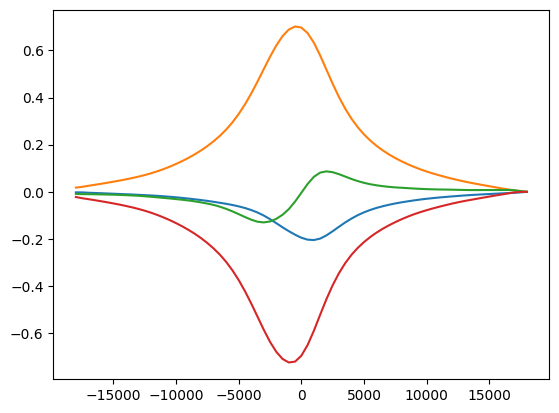

In [25]:
plt.plot(RV, train_data[0,10,:])
plt.plot(RV, train_data[1,22,:])
plt.plot(RV, train_data[46,2,:])
plt.plot(RV, train_data[110,3,:])

## Latent space dimension

In [ ]:
input_shape = (27,73,1)
# http://users.jyu.fi/~olkhriye/ties4911/lectures/Lecture03.pdf
#https://learnopencv.com/autoencoder-in-tensorflow-2-beginners-guide/
latent_dims = np.arange(1,51,1)
lossesvec = []
for i in range(2):
    for k in range(len(latent_dims)):
        class Autoencoder(Model):
            def __init__(self, input_shape, latent_dim):
                super(Autoencoder, self).__init__()
                self.latent_dim = latent_dims[k]
                self.encoder = tf.keras.Sequential([
                    #block1
                    layers.Input(batch_shape=(None, 27,73,1)),
                    layers.Conv2D(16, kernel_size=(3,3), activation='tanh', padding='same'),
                    #block3
                    layers.Conv2D(16, kernel_size=(3,3), activation='tanh', padding='same'),
                    #final
                    layers.Flatten(),
                    layers.Dense(64, activation='tanh'),
                    layers.Dense(latent_dims[k], activation='tanh'),
                ])

                self.decoder = tf.keras.Sequential([
                    #block1
                    layers.Dense(64, activation='tanh'),
                    layers.Dense(73*16*27, activation='tanh'),
                    layers.Reshape((27,73,16)), 
                    #block2
                    layers.Conv2D(16, kernel_size=(3,3), activation='tanh', padding='same'),
                    #block3
                    layers.Conv2D(16, kernel_size=(3,3), activation='tanh', padding='same'),
                    #final
                    layers.Conv2D(1, kernel_size=(3,3), activation='linear', padding='same')  
                ])

            def call(self, x):
                encoded = self.encoder(x)
                decoded = self.decoder(encoded)
                return decoded

        autoencoder = Autoencoder(input_shape, latent_dims[k])

        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.01, patience=5, min_lr=1e-10)

        initial_learning_rate = 0.001
        autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                      loss='mse')

        optimizer = tf.keras.optimizers.Adam()


        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


        history = autoencoder.fit(train_data, train_data,
                                  epochs=30,
                                  shuffle=True,
                                  batch_size=128,
                                   callbacks=[reduce_lr, early_stopping], validation_data= [val_data,val_data])

        lossesvec2 = history.history['val_loss'][-1]
        lossesvec.append(lossesvec2)

Text(0.5, 0, 'Number of nodes')

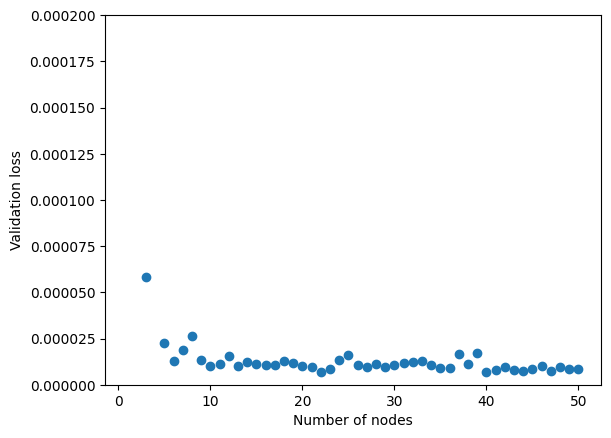

In [51]:
plt.scatter(latent_dims, lossesvec[0:50])
plt.ylim((0.000,0.0002))
plt.ylabel('Validation loss')
plt.xlabel('Number of nodes')

In [72]:
np.square(np.array(lossesvec[0:50])-np.array(lossesvec[50:100]))

array([3.72374354e-10, 5.01413411e-09, 1.05423431e-06, 1.14357982e-06,
       1.19255924e-06, 7.81401809e-12, 2.69466428e-11, 4.93795444e-11,
       4.31208683e-12, 2.13229858e-12, 1.41585656e-11, 3.04623259e-11,
       1.06979147e-11, 6.65767186e-12, 8.19763937e-11, 2.76906523e-13,
       5.90196426e-12, 6.33012211e-12, 2.24925125e-12, 2.66691925e-14,
       9.10277577e-11, 3.13180757e-11, 3.61687018e-12, 2.39293426e-13,
       4.55813307e-11, 1.64179808e-11, 2.56089309e-11, 7.81662677e-14,
       1.93024080e-13, 2.51754651e-11, 2.06442924e-13, 3.98289706e-12,
       2.81046496e-11, 6.00599671e-12, 6.94960391e-13, 1.91440840e-11,
       5.86263267e-11, 2.82507013e-11, 5.88489895e-11, 1.21010397e-10,
       2.10147962e-11, 3.01936943e-12, 3.24862360e-12, 1.97121198e-10,
       7.26516331e-14, 1.41016496e-11, 8.60348080e-12, 6.74639913e-15,
       1.36250452e-12, 1.75433155e-11])

In [43]:
np.sqrt(np.sum(np.square(np.array(lossesvec[0:50])-np.array(lossesvec[50:100]))))

0.0018430516595222088

## Latent space 

In [ ]:
input_shape = (27,73,1)

latent_dim = 3


class Autoencoder(Model):
    def __init__(self, input_shape, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            #block1
            layers.Input(batch_shape=(None, 27,73,1)),
            layers.Conv2D(16, kernel_size=(3,3), activation='tanh', padding='same'),
            #block3
            layers.Conv2D(16, kernel_size=(3,3), activation='tanh', padding='same'),
            #final
            layers.Flatten(),
            layers.Dense(64, activation='tanh'),
            layers.Dense(latent_dim, activation='tanh'),
        ])

        self.decoder = tf.keras.Sequential([
            #block1
            layers.Dense(64, activation='tanh'),
            layers.Dense(73*16*27, activation='tanh'),
            layers.Reshape((27,73,16)), 
            #block2
            layers.Conv2D(16, kernel_size=(3,3), activation='tanh', padding='same'),
            #block3
            layers.Conv2D(16, kernel_size=(3,3), activation='tanh', padding='same'),
            #final
            layers.Conv2D(1, kernel_size=(3,3), activation='linear', padding='same')  
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(input_shape, latent_dim)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.01, patience=5, min_lr=1e-10)

initial_learning_rate = 0.001
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                          loss='mse')

optimizer = tf.keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


history = autoencoder.fit(train_data, train_data,
                            epochs=30,
                            shuffle=True,
                            batch_size=128,
                            callbacks=[reduce_lr, early_stopping], validation_data= [val_data,val_data])

            

In [23]:
test_matrices = {}
n= 50
for i in range(n):
    filename = f'STARSIM_output_CCFra_{i}.txt'
    test_matrix = np.loadtxt(filename)
    test_matrices[f'd{i}'] = test_matrix
    
for i in range(n):
    test_matrices[f'd{i}'] = test_matrices[f'd{i}'][:,1:]
for i in range(n):
    test_matrices[f'd{i}'] = test_matrices[f'd{i}'].T
    

ccf_total = {}

for i in range(n):
    for j in range(73):
        a = 0
        for k in range(27):
            a += test_matrices[f'd{i}'][k,j]
        ccf_total[f'd{i}',j] = a
    

for i in range(n):
    ccf_total1 = np.zeros(73)
    for k in range(27):
        for j in range(73):
            ccf_total1[j] = ccf_total[f'd{i}',j]/27
        for l in range(73):
            test_matrices[f'd{i}'][k,l] = test_matrices[f'd{i}'][k,l]- ccf_total1[l]


for i in range(n):
    test_matrices[f'd{i}']=test_matrices[f'd{i}']/maxim

    
test_radius = []
for i in range(50):
    test_radius.append(test_matrices[f'd{i}'])

test_radius = np.array(test_radius).reshape(n,27,73,1)

In [24]:
test_matrices2 = {}
n= 50
for i in range(n):
    filename = f'STARSIM_output_CCFlong_{i}.txt'
    test_matrix = np.loadtxt(filename)
    test_matrices2[f'd{i}'] = test_matrix
    
for i in range(n):
    test_matrices2[f'd{i}'] = test_matrices2[f'd{i}'][:,1:]
for i in range(n):
    test_matrices2[f'd{i}'] = test_matrices2[f'd{i}'].T
    

ccf_total = {}

for i in range(n):
    for j in range(73):
        a = 0
        for k in range(27):
            a += test_matrices2[f'd{i}'][k,j]
        ccf_total[f'd{i}',j] = a
    

for i in range(n):
    ccf_total1 = np.zeros(73)
    for k in range(27):
        for j in range(73):
            ccf_total1[j] = ccf_total[f'd{i}',j]/27
        for l in range(73):
            test_matrices2[f'd{i}'][k,l] = test_matrices2[f'd{i}'][k,l]- ccf_total1[l]


for i in range(n):
    test_matrices2[f'd{i}']=test_matrices2[f'd{i}']/0.1
    
for i in range(n):
    test_matrices2[f'd{i}'] = np.reshape(test_matrices2[f'd{i}'],27*73)
    
    
test_long = []
for i in range(50):
    test_long.append(test_matrices2[f'd{i}'])

test_long = np.array(test_long).reshape(n,27,73,1)


In [25]:
latentra = autoencoder.encoder.predict(test_radius)
latentlo = autoencoder.encoder.predict(test_long)

2/2 [==============================] - 0s 4ms/step


In [69]:
np.shape(latentra)

(50, 3)

In [26]:
radius = np.arange(41,56,0.3)
long = np.arange(270,357,1.75)

In [ ]:
plt.plot(latentra[:,0], radius, color='red', label= 'Latent dimension 1')
plt.plot(latentra[:,1], radius, color='blue', label= 'Latent dimension 2')
plt.plot(latentra[:,2], radius, color='orange', label= 'Latent dimension 3')
plt.xlabel('Latent dimension value')
plt.ylabel('Radius')
plt.legend()

In [ ]:
plt.plot(latentlo[:,0], long, color='red', label= 'Latent dimension 1')
plt.plot(latentlo[:,1], long, color='blue', label= 'Latent dimension 2')
plt.plot(latentlo[:,2], long, color='orange', label= 'Latent dimension 3')
plt.xlabel('Latent dimension value')
plt.ylabel('Longitude')
plt.legend()

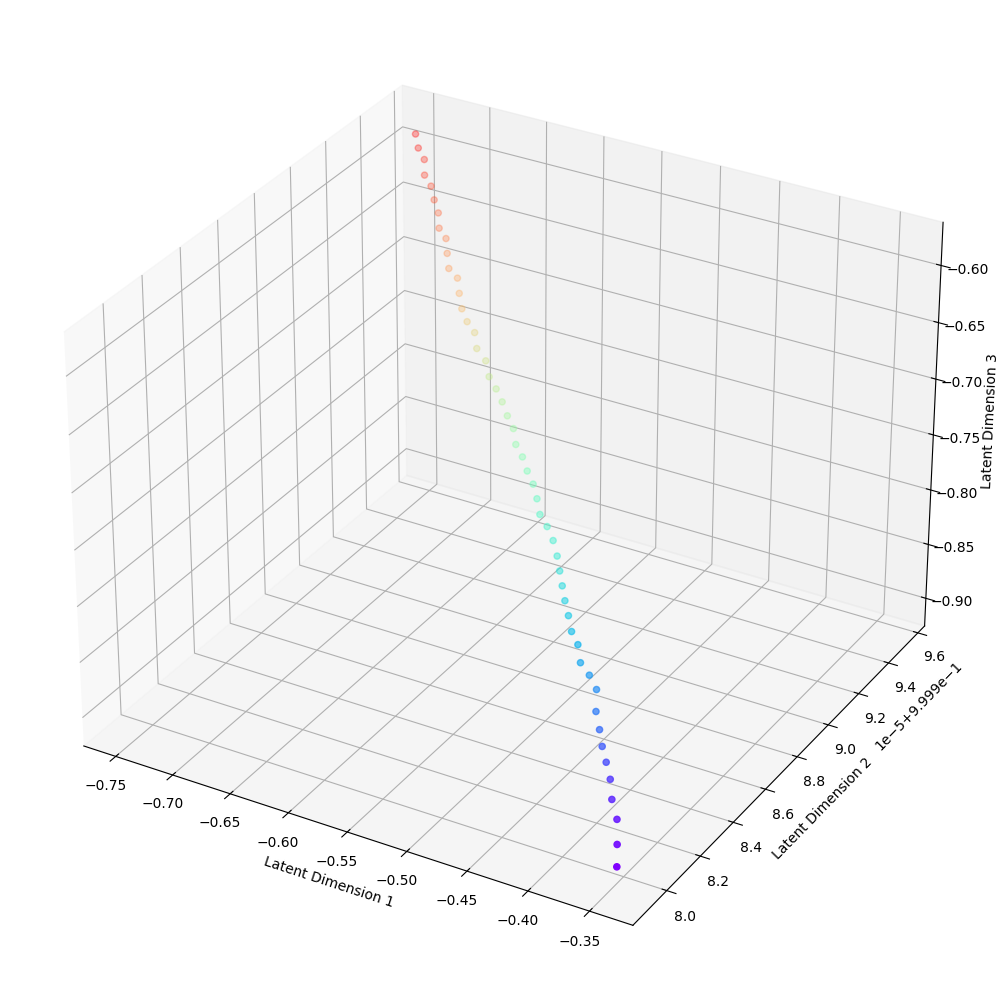

In [29]:
fig = plt.figure(figsize=(20, 20))

jet=plt.get_cmap('rainbow')
colors1=jet(np.linspace(0,1,len(radius)))



x1 = np.array([point[0] for point in latentra])
y1 = np.array([point[1] for point in latentra])
z1 = np.array([point[2] for point in latentra])

ax1 = fig.add_subplot(221, projection='3d')


ax1.scatter(x1, y1, z1, color = colors1)


ax1.set_xlabel('Latent Dimension 1')
ax1.set_ylabel('Latent Dimension 2')
ax1.set_zlabel('Latent Dimension 3')

plt.tight_layout()
plt.show()


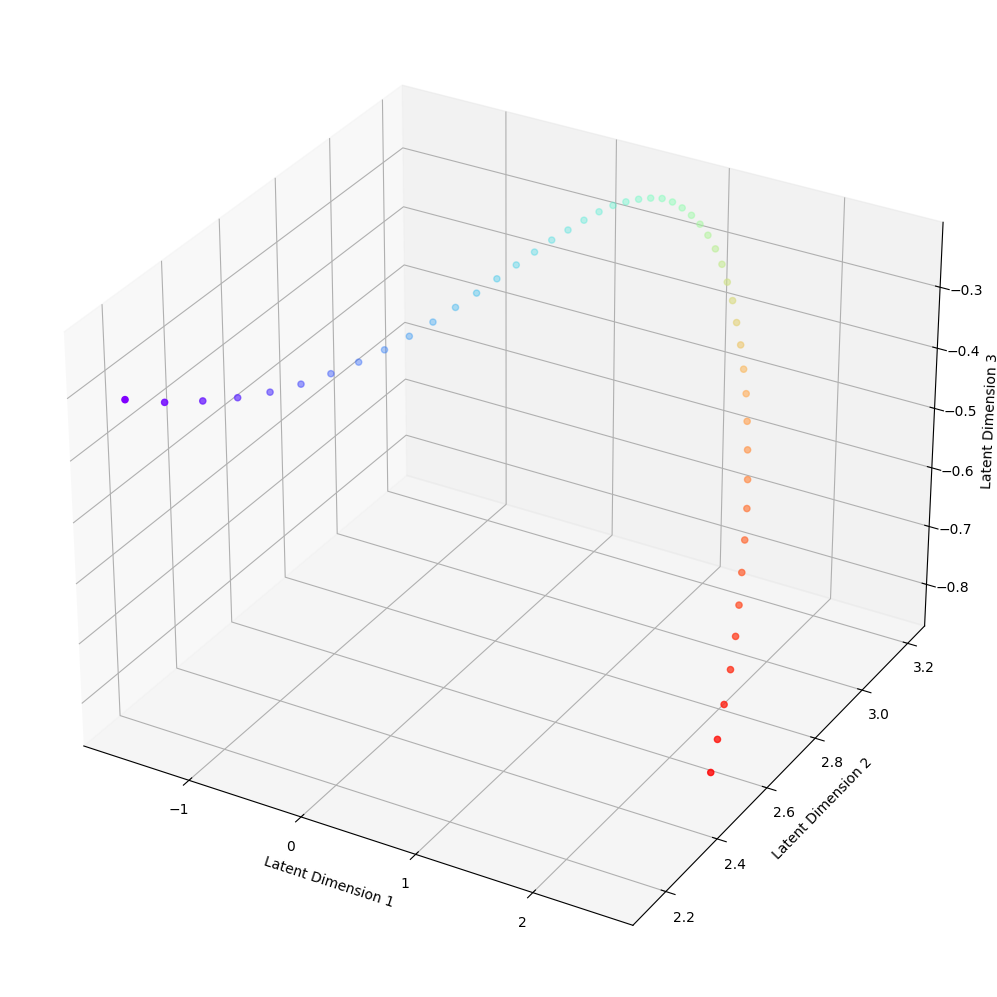

In [64]:
fig = plt.figure(figsize=(20, 20))

jet=plt.get_cmap('rainbow')
colors1=jet(np.linspace(0,1,len(radius)))



x1 = np.array([point[0] for point in latentlo])
y1 = np.array([point[1] for point in latentlo])
z1 = np.array([point[2] for point in latentlo])

ax1 = fig.add_subplot(221, projection='3d')


ax1.scatter(x1, y1, z1, color = colors1)


ax1.set_xlabel('Latent Dimension 1')
ax1.set_ylabel('Latent Dimension 2')
ax1.set_zlabel('Latent Dimension 3')

plt.tight_layout()
plt.show()
